In [1]:
import simpy
import itertools
import numpy as np
import matplotlib.pyplot as plt

## SINGLE-SERVER QUEUEING SYSTEM

Processes
- arrival 
- service

#### Generating all cars

In [2]:
def car(env, name, bcs, driving_time, charge_duration):
    # Simulate driving to Charging Station
    yield env.timeout(driving_time)
    
    # Request one of it's charging stations
    print('car {} is arriving at {:.0f}'.format(name, env.now))
    with bcs.request() as req:
        yield req
        
        # Charge the battery
        print('starting to charge Car {} at {}'.format(name, env.now))
        yield env.timeout(charge_duration)
        print('Car {} finished charging at {}'.format(name, env.now))
    

In [3]:
env = simpy.Environment()
bcs = simpy.Resource(env, capacity=2)
env.process(car(env, "1", bcs, 1, 5))
env.process(car(env, "2", bcs, 2, 5))
env.process(car(env, "3", bcs, 3, 5))
env.process(car(env, "4", bcs, 4, 5))
env.run(until=60)

car 1 is arriving at 1
starting to charge Car 1 at 1
car 2 is arriving at 2
starting to charge Car 2 at 2
car 3 is arriving at 3
car 4 is arriving at 4
Car 1 finished charging at 6
starting to charge Car 3 at 6
Car 2 finished charging at 7
starting to charge Car 4 at 7
Car 3 finished charging at 11
Car 4 finished charging at 12


#### with car generator

In [4]:
sim_time = 100
servers = 4

arrival_rate = 20 #arrivals/hour 
service_rate = 5 #service/hour 

In [5]:
arrival_times = []
start_service_times = []
finish_service_times = []

In [6]:
def car(env, name, queue, charge_duration):
    arrival_time = env.now
    arrival_times.append(arrival_time)
#     print('{} is arriving at {:.2f}'.format(name, env.now))
    with queue.request() as req:
        yield req
        
        # Start serving
        waiting_time = env.now - arrival_time
#         print('starting to serve {} at {:.2f}'.format(name, env.now))
        start_service_times.append(env.now)

        # Finish serving
        yield env.timeout(np.random.exponential(charge_duration))
#         print('{} finished serving at {:.2f}'.format(name, env.now))
        finish_service_times.append(env.now)# - waiting_time - arrival_time)
    

In [7]:
def car_generator(env, queue):
    interarrival_time = 60/arrival_rate
    charge_duration = 60/service_rate
    """Generate new cars that arrive at the gas station."""
    for i in itertools.count():
#     for i in range(1,5):
        yield env.timeout(np.random.exponential(interarrival_time))
        
        env.process(car(env, 'Car %d' % i, queue, charge_duration ))
    return i

In [8]:
env = simpy.Environment()
queue = simpy.Resource(env, capacity=servers)
proc = env.process(car_generator(env, queue))
env.run(until=sim_time)

In [9]:
def acum(l):
#     t = np.arange(0,sim_time,0.01)
    Acum = np.zeros(sim_time*100)
    for e in l:
        idx = int(e*100)
        Acum[idx:]+=1
#     plt.plot(t,l)
#     plt.show()
    return Acum

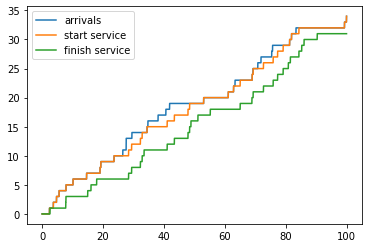

In [52]:
t = np.arange(0,sim_time,0.01)
plt.plot(t,acum(arrival_times), label="arrivals")
plt.plot(t,acum(start_service_times), label="start service")
plt.plot(t,acum(finish_service_times), label="finish service")
# plt.plot(t,acum(waiting_times))
plt.legend()
plt.show()

## SIMULATION OF AN INVENTORY SYSTEM

The **times between demands** are IID exponential random variables with a mean of 0.1 month.

(array([48., 21.,  6., 10.,  9.,  4.,  1.,  0.,  0.,  1.]),
 array([ 0.02353896,  1.5683179 ,  3.11309684,  4.65787579,  6.20265473,
         7.74743367,  9.29221261, 10.83699156, 12.3817705 , 13.92654944,
        15.47132838]),
 <BarContainer object of 10 artists>)

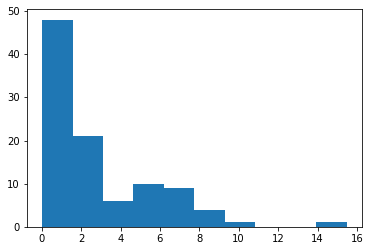

In [11]:
plt.hist(np.random.exponential(0.1*30, size=100))

The **Demand size** is D, are IID random variables (independent of when the demands occur), with

(array([160.,   0.,   0., 335.,   0.,   0., 339.,   0.,   0., 166.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

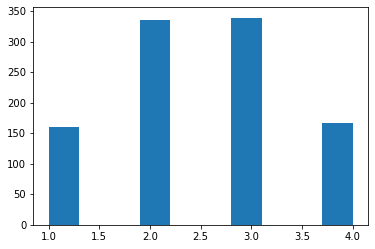

In [12]:
plt.hist(np.random.choice([1,2,3,4],1000, p=[1/6, 1/3, 1/3, 1/6]))

**Order** of Z items

(array([12.,  4., 13., 18.,  9., 10.,  4.,  5., 10., 15.]),
 array([0.50333018, 0.55272195, 0.60211372, 0.65150549, 0.70089726,
        0.75028903, 0.7996808 , 0.84907257, 0.89846434, 0.94785611,
        0.99724788]),
 <BarContainer object of 10 artists>)

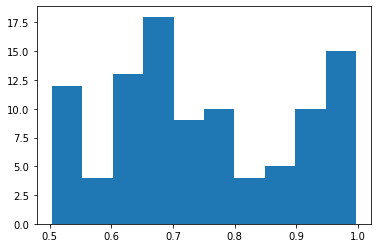

In [13]:
plt.hist([np.random.rand()/2+0.5 for i in range(100)])

In [14]:
S = 100
s = 5
stock_0 = 15
backlog_0 = 0

In [45]:
if True: print("hello"); print("joan");print("ddw")

hello
joan
ddw


In [98]:
class System:
    def __init__(self, env, stock_max, stock_min, stock_ini, backlog_ini ):
        self.env = env
        self.S = stock_max
        self.s = stock_min
        self.stock_0 = stock_ini
        self.backlog_0 = backlog_ini
        self.inventory = simpy.Container(self.env, self.S, self.stock_0)
        self.backlog = simpy.Container(self.env, 1000, self.backlog_0)
        
        self.I = [(0,stock_ini)]
        self.B = [(0,backlog_ini)]
        
        # Start the run process everytime an instance is created.
        self.action1 = env.process(self.order())
        self.action2 = env.process(self.demand())
            
    def order(self):
        for i in itertools.count():
            #order each month
            yield self.env.timeout(30) 
            if self.inventory.level<self.s:

                order_size = self.S - self.inventory.level 
                print("start order {} of {} at day {}".format(i,order_size, self.env.now, self.inventory.level)) 
                yield self.env.timeout((np.random.rand()/2+0.5)*30)

                added_stock = order_size - self.backlog.level
                
                if self.backlog.level>0: self.backlog.get(self.backlog.level); self.append_backlog()
                if added_stock>0: self.inventory.put(added_stock); self.append_stock()
                    

                print("recieved order {} of {} at day {}, stock at {}".format(i,order_size, self.env.now, self.inventory.level)) 

            else:
                print("order of {} at day {}".format(0, self.env.now)) 


    def demand(self):
        while True:
            # demand every 0.1  months

            yield self.env.timeout(np.random.exponential(0.1*30)) 

            demand_size = np.random.choice([1,2,3,4], p=[1/6, 1/3, 1/3, 1/6])

            # demand from inventory
            if self.inventory.level-demand_size>0:
                self.inventory.get(demand_size)
                self.append_stock()

            # Inventory + Backlog
            else: 
                B = demand_size - self.inventory.level
                I = self.inventory.level

                if B>0: self.backlog.put(B); self.append_backlog()
                if I>0: self.inventory.get(I); self.append_stock()


    #         print("demand {} at day {}".format(demand_size, env.now))
            print("demand {}, inventory {}".format(demand_size, self.inventory.level))
        
        
    def append_stock(self):
        self.I.append((self.env.now, self.inventory.level))
    
    def append_backlog(self):
        self.B.append((self.env.now, self.backlog.level))

            


In [99]:
stock_max, stock_min, stock_ini, backlog_ini = (100, 5, 15, 0)
sim_time = 1000
env = simpy.Environment()
system = System(env, stock_max, stock_min, stock_ini, backlog_ini)
env.run(until=sim_time)

demand 3, inventory 12
demand 3, inventory 9
demand 4, inventory 5
demand 2, inventory 3
start order 0 of 97 at day 30
demand 3, inventory 0
demand 1, inventory 0
demand 3, inventory 0
demand 1, inventory 0
demand 3, inventory 0
demand 3, inventory 0
demand 1, inventory 0
demand 4, inventory 0
demand 3, inventory 0
recieved order 0 of 97 at day 58.567197792808585, stock at 78
demand 2, inventory 76
demand 1, inventory 75
demand 3, inventory 72
demand 1, inventory 71
demand 2, inventory 69
demand 2, inventory 67
demand 3, inventory 64
demand 3, inventory 61
demand 4, inventory 57
demand 4, inventory 53
demand 3, inventory 50
demand 2, inventory 48
order of 0 at day 88.56719779280859
demand 4, inventory 44
demand 2, inventory 42
demand 1, inventory 41
demand 3, inventory 38
demand 2, inventory 36
demand 2, inventory 34
demand 3, inventory 31
demand 2, inventory 29
order of 0 at day 118.56719779280859
demand 2, inventory 27
demand 3, inventory 24
demand 3, inventory 21
demand 3, inventory

In [100]:
def acum(data):
    l = np.zeros(sim_time*100)
    l[:] = data[0][1]
    for i in range(1,len(data)):
        idx = int(data[i][0]*100)
        value = data[i][1]
        l[idx:] = value
    return l


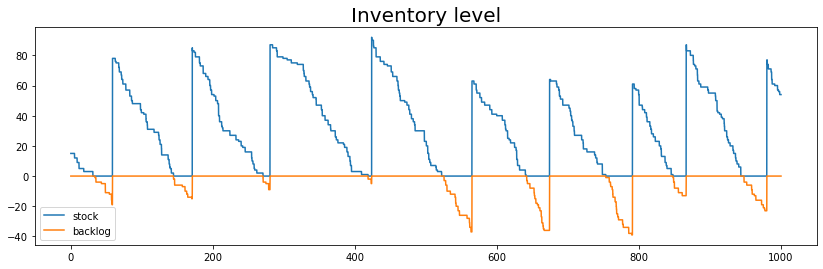

In [101]:
t = np.arange(0,sim_time,0.01)
plt.figure(figsize=(14,4))
plt.title("Inventory level",size=20)
plt.plot(t,acum(system.I), label="stock")
plt.plot(t,-acum(system.B), label="backlog")
# plt.plot(t,acum(system.I)-acum(system.B), label="I(t)")
# plt.plot(t,acum(waiting_times))
plt.legend()
plt.show()